In [138]:
import sys
import csv
import numpy as np
import pandas as pd
import math
from itertools import product
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize, MinMaxScaler, StandardScaler
from sklearn import linear_model, tree, grid_search
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from joblib import Parallel, delayed

le = preprocessing.LabelEncoder()

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

df  = pd.read_csv('dane_treningowe.csv')
final_df = pd.read_csv('dane_testowe.csv')

df = pd.concat([df, final_df])

def przerwa_transform(x):
    if x == 999:
        return 1
    if x < 3:
        return 0
    if x < 10:
        return 0.3
    return 0.6

def wiek_transform(x):
    if x >= 65:
        return 100
    if x < 22:
        return 18
    else:
        return int(math.ceil(x / 10.0)) * 10

def wyksztalcenie_transform(x):
    lista = [('illiterate',           1), 
             ('basic.4y',             0.5), 
             ('basic.6y',             0),
             ('basic.9y',             0.3),
             ('high.school',          0.6),
             ('unknown',              0.9),
             ('professional.course',  0.7),
             ('university.degree',    0.8)]

    for (a,b) in lista:
        if x == a:
            return b
    
    return -42

def zawod_transform(x):
    lista = [('unemployed',            0.8), 
             ('student',               1),
             ('housemaid',             0.2),
             ('services',              0.05),
             ('retired',               0.9),
             ('unknown',               0.3),
             ('blue-collar',           0),
             ('admin.',                0.7),
             ('technician',            0.5),
             ('self-employed',         0.6),
             ('entrepreneur',          0.1),
             ('management',            0.4)]

    for (a,b) in lista:
        if x == a:
            return b
    return -42
    

df['rezultat'] = df['rezultat'].map(lambda x: 1 if x == 'yes' else 0)
df['przerwa'] = df['przerwa'].map(przerwa_transform)
df['wyksztalcenie'] = df['wyksztalcenie'].map(wyksztalcenie_transform)
df['zawod'] = df['zawod'].map(zawod_transform)
df['wiek']  = df['wiek'].map(wiek_transform)

parameters_to_num = ['stan_cywilny', 'debet', 'hipoteka', 'pozyczka', 'poprzedni_wynik']

for p in parameters_to_num:
    df[p] = le.fit_transform(df[p])
    


def scale():
    for col in list(df.columns.values):
        if col != 'rezultat' and col != 'id_klienta':
            df[col] = MinMaxScaler().fit_transform(df[col])
        
scale()

final_df = df[28000:]
df = df[:27999]

np.random.randn(42)
msk = np.random.rand(len(df)) < 0.8

train_df = df[msk]
test_df  = df[~msk]


def preprocess(_df):
    _df = _df.drop('CCI', axis=1)
    
    if 'rezultat' in _df:
        X = _df.drop('rezultat', axis=1)
        Y = _df['rezultat']
    else:
        X = _df
        Y = _df
    return (X,Y)

def train_test_score(clf):
    test_P = clf.predict(test_X)
    train_P = clf.predict(train_X)
    fpr, tpr, thresholds = metrics.roc_curve(test_Y, test_P, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    
    f1 = f1_score(test_Y, test_P)
    f2 = f1_score(train_Y, train_P)
    return (f1, f2)
    
def score_classifier(clf):
    test_P = clf.predict(test_X)
    train_P = clf.predict(train_X)
    test_PP = clf.predict_proba(test_X)
    fpr, tpr, thresholds = metrics.roc_curve(test_Y, test_PP[:,1], pos_label=1)
    auc = metrics.auc(fpr, tpr)
    
    f1 = f1_score(test_Y, test_P)
    f1_train = f1_score(train_Y, train_P)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    title = "ROC Curve. AUC = " + str(auc) + " F1 TEST = " + str(f1) + "F1 TRAIN = " + str(f1_train)
    plt.title(title)
    plt.show()
    target_names = ['NIE', 'TAK']
    print(metrics.classification_report(test_Y, test_P, target_names=target_names))

(train_X, train_Y) = preprocess(train_df)
(test_X, test_Y)   = preprocess(test_df)
(final_X, _)       = preprocess(final_df)

In [94]:
answers = []
column = 'wiek'

for zawod in df[column].unique():
    df2 = df[df[column] == zawod]
    rez = float(df2[df2['rezultat'] == 1].count()['rezultat']) / df2.count()['rezultat'] * 100
    answers.append ((rez, "i = "  + str(zawod) + " rez = " + str(rez)  + "%" + " support: " + str(df2.count()[0])))

for (a,b) in sorted(answers):
    print b

i = 0.390243902439 rez = 8.12482024734% support: 6954
i = 0.268292682927 rez = 9.94652406417% support: 11220
i = 0.512195121951 rez = 10.7455621302% support: 4225
i = 0.146341463415 rez = 14.4400581758% support: 4813
i = 0.0 rez = 34.9397590361% support: 166
i = 0.634146341463 rez = 39.7660818713% support: 171
i = 1.0 rez = 47.2283813747% support: 451


Analiza danych
--------------

In [95]:
df2 = df.corr()
df2['rezultat'].sort_values()

wskaznik_zatrudnienia    -0.357718
przerwa                  -0.327777
EURIBOR3M                -0.310161
zmiennosc_zatrudnienia   -0.297650
CPI                      -0.130314
debet                    -0.101487
liczba_kontaktow         -0.067018
pozyczka                 -0.002850
id_klienta                0.010672
hipoteka                  0.014809
stan_cywilny              0.044316
CCI                       0.049454
wiek                      0.057043
wyksztalcenie             0.064619
zawod                     0.123755
poprzedni_wynik           0.135674
poprzednie                0.238842
rezultat                  1.000000
Name: rezultat, dtype: float64

Łatwo zauważyć, że szczególnie istotne parametry które w liniowy sposób wpływają na wynik to odpowiednio
* wskaźnik_zatrudnienia (35%)
* przerwa (33%)
* EURIBOR3m (31%)
* zmiennosc_zatrudnienia (29%)
* poprzednie (23%)
* poprzednie_wynik (13%)
* CPI (13%)
* debet (10%)

Dodatkowo warto zauważyć, że wysoki wpływ wskaźników EURIBOR3M, CPI, wskaźnik_zatrudnienia oraz zmienność_zatrudnienia wynika z tego, że każdy z nich niesie informacje o tym, w jakim dniu został nawiązany kontakt z klientem. Z konkretnym okresem może być związanych dużo innych zdarzeń, w szczególności wyjątkowe promocje, oferty czy kampanie reklamowe.

Algorytm
---------

Sprawdzam, czy istnieje korelacja między klasą decyzyjną a pozostałymi kolumnami zbioru danych

Na podstawie powyższej tabelki można stwierdzić, iż istnieje statystycznie istotna korelacja między wartościami w kolumnach C* a wartością klasy decyzyjnej

Następnie sprawdzam korelacje między kolumnami C*

Tym razem możemy stwierdzić brak statystycznie istotnej korelacji między kolumnami. Wobec tego, użycie klasyfikatora działającego liniowo względem danych powinno być wystarczające.



Następnie sprawdzam liczność klasy decyzyjnych z "1" oraz "0"

Ponieważ rozkład "1" oraz "0" w klasie decyzyjnej jest równomierny, nie jest konieczne użycie F-Score do wyznacznia dokładności klasyfikatora, wystarczy policzyć precyzję na zbiorze testowym

----------------------------------------------------

Poniżej przedstawiam przebieg i wyniki badań. GridSearchCV jest funkcją, która automatycznie dopasowuje najlepsze parametry z podanych list na podstawie wyniku na walidacji krzyżowej.

Jakość ostatecznego wyniku dla każdego z algorytmów zbadałem na zbiorze testowym.

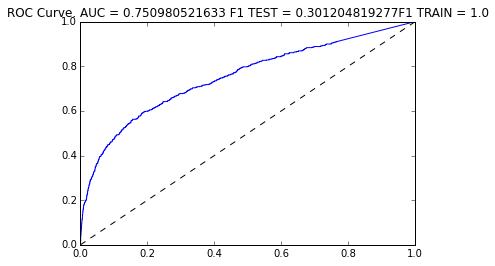

             precision    recall  f1-score   support

        NIE       0.91      0.98      0.94      4958
        TAK       0.59      0.20      0.30       617

avg / total       0.87      0.90      0.87      5575



In [124]:
knc = KNeighborsClassifier(n_neighbors = 24, weights='distance', algorithm='brute')
knc.fit(train_X, train_Y)
score_classifier(knc)

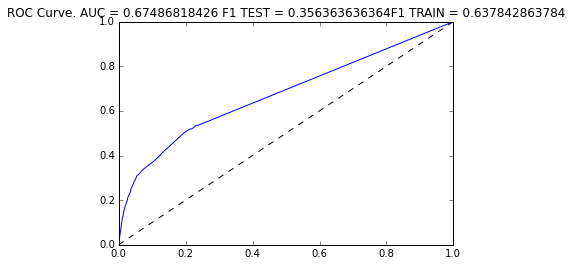

NameError: global name 'target_names' is not defined

In [113]:
dtc = tree.DecisionTreeClassifier()

parameters = {
    'max_depth': (25,50,75,100,200, 500),
    'min_samples_split': (5, 6,7,8, 15),
    'min_samples_leaf': (5,7,8,9,10, 20)
}

clf = grid_search.GridSearchCV(dtc, parameters, n_jobs=-1, scoring='f1')
clf.fit(train_X, train_Y)
score_classifier(clf)

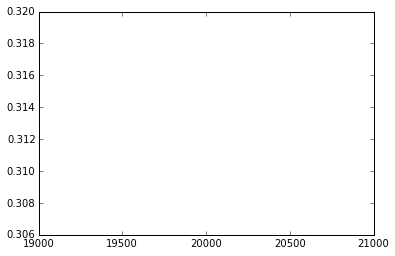

In [120]:
def licz(nte, sd):
    mlp = MLPClassifier(max_iter=2000, random_state = sd)
    parameters = {'hidden_layer_sizes':range(3,10)}
    clf = grid_search.GridSearchCV(mlp, parameters, n_jobs=2, scoring='f1')
    clf.fit(train_X[1:nte], train_Y[1:nte])
    return train_test_score(clf)

result_i   = []
result_auc = []
result_aac = []

for num in [20000]:
    ans_acc  = 0
    test_acc = 0
    res = Parallel(n_jobs=6)(delayed(licz)(num, (i)) for i in range(10))
    
    ans_acc = 0
    test_acc = 0
    for a, b in res:
        ans_acc += a
        test_acc += b
        
    result_i.append(num)
    result_auc.append(ans_acc/10)
    result_aac.append(test_acc/10)

plt.plot(result_i, result_auc, 'g', result_i, result_aac, 'r')

Podsumowanie
------------

Jak wynika z poniższej tabelki, najlepszy wynik spośród sprawdzonych algorytmów można uzyskać stosując sieć neuronową o 10 warstwach ukrytych i jest to 89.7%. Z poznanych do tej pory algorymtów najlepiej sprawdził się algorytm Naive Bayes z dokładnością klasyfikacji 86.4%.

NotFittedError: This MLPClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

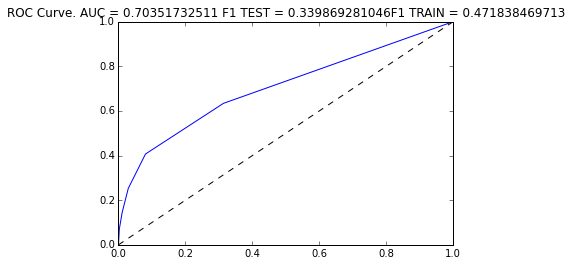

             precision    recall  f1-score   support

        NIE       0.91      0.97      0.94      4958
        TAK       0.52      0.25      0.34       617

avg / total       0.87      0.89      0.87      5575



In [119]:
knc = KNeighborsClassifier(weights='uniform', algorithm='brute')
knc.fit(train_X, train_Y)
score_classifier(knc)

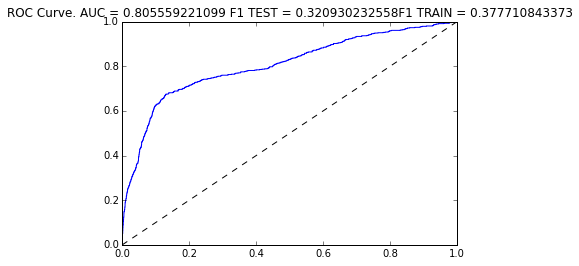

             precision    recall  f1-score   support

        NIE       0.90      0.99      0.94      4991
        TAK       0.70      0.21      0.32       662

avg / total       0.88      0.90      0.87      5653



In [139]:
dtc = RandomForestClassifier(max_features= 'sqrt' ,n_estimators=50, oob_score = True)
parameters = {
    'max_depth':range(5,80,5),
    'min_samples_leaf':range(5,15,5),
}
clf = grid_search.GridSearchCV(dtc, parameters, n_jobs=-1, scoring='f1')
clf.fit(train_X, train_Y)
score_classifier(clf)

Obliczanie ostatecznego wyniku 

In [172]:
#arr = clf.predict_proba(final_X)
'''
ids = df_final['id_klienta']
ids_list = []

count = 0
for i in range(0, len(arr[:,0])):
    if (arr[:,0][i] < 0.66):
        count = count + 1
        ids_list.append(str(ids[i]))

for i in range(0, len(arr[:,0])):
    if (arr[:,0][i] < 0.86) and count < 1000:
        count = count + 1
        ids_list.append(str(ids[i]))

answer = pd.DataFrame(ids_list)
answer.to_csv('answer.csv', sep='\t', columns=[0])
'''
ids = final_X['id_klienta']
np.set_printoptions(threshold='nan')
#len(arr[arr[:,1] > 0.3958])
for i in range(0, 13188):
    if (arr[i,1] > 0.3958):
        print ids[i]

38008
38033
38041
38058
38062
38068
38072
38093
38112
38122
38148
38157
38161
38167
38207
38213
38214
38217
38252
38295
38301
38313
38318
38331
38349
38353
38358
38370
38371
38381
38421
38426
38440
38454
38530
38575
38577
38578
38585
38596
38599
38663
38681
38683
38690
38693
38723
38738
38757
38773
38775
38776
38787
38798
38809
38812
38862
38870
38873
38874
38878
38881
38920
38936
38973
38975
38994
39022
39040
39052
39058
39064
39078
39092
39123
39135
39141
39169
39198
39239
39249
39259
39306
39316
39326
39330
39362
39364
39366
39384
39389
39397
39426
39427
39430
39434
39437
39459
39467
39491
39511
39526
39548
39580
39609
39610
39633
39636
39651
39657
39665
39679
39699
39729
39730
39740
39745
39774
39775
39809
39815
39820
39821
39842
39851
39917
39926
39928
39969
39974
39981
39991
39995
39999
40011
40019
40037
40041
40056
40099
40108
40112
40114
40124
40129
40141
40158
40169
40182
40183
40188
40192
40197
40203
40212
40221
40248
40257
40258
40259
40261
40268
40277
40292
40306
40308
4031

In [130]:
df

,CCI,CPI,EURIBOR3M,debet,hipoteka,id_klienta,liczba_kontaktow,poprzedni_wynik,poprzednie,pozyczka,przerwa,rezultat,stan_cywilny,wiek,wskaznik_zatrudnienia,wyksztalcenie,zawod,zmiennosc_zatrudnienia
0,0.615063,0.484412,0.981637,0.0,1.0,0.000000,0.000000,0.5,0.000000,1.0,1.0,0,0.666667,0.268293,1.000000,0.8,0.50,1.000000
1,0.192469,0.269680,0.143278,0.0,1.0,0.000024,0.000000,0.0,0.142857,0.0,1.0,0,0.333333,0.390244,0.512287,0.6,0.05,0.333333
2,0.615063,0.484412,0.982090,0.0,0.5,0.000049,0.036364,0.5,0.000000,0.5,1.0,0,0.666667,0.268293,1.000000,0.7,0.50,1.000000
3,0.376569,0.882307,0.980957,0.0,1.0,0.000073,0.018182,0.5,0.000000,0.0,1.0,0,0.333333,0.268293,1.000000,0.7,0.00,1.000000
4,0.602510,0.698753,0.957379,0.0,1.0,0.000097,0.036364,0.5,0.000000,1.0,1.0,0,0.000000,0.390244,0.859735,0.3,0.70,0.937500
5,0.192469,0.269680,0.138291,0.0,0.0,0.000121,0.018182,0.5,0.000000,0.0,1.0,0,0.333333,0.268293,0.512287,0.8,0.10,0.333333
6,0.368201,0.389322,0.790297,0.0,0.0,0.000146,0.036364,0.0,0.142857,0.0,1.0,0,0.333333,0.268293,0.877883,0.6,0.05,0.687500
7,0.376569,0.882307,0.980957,0.0,1.0,0.000170,0.000000,0.5,0.000000,1.0,1.0,0,0.333333,0.268293,1.000000,0.8,0.70,1.000000
8,0.368201,0.389322,0.806393,0.0,0.0,0.000194,0.000000,0.5,0.000000,0.0,1.0,0,0.333333,0.268293,0.877883,0.0,0.40,0.687500
9,0.192469,0.269680,0.139651,0.0,1.0,0.000219,0.000000,0.0,0.142857,0.0,1.0,0,0.333333,0.390244,0.512287,0.8,0.60,0.333333


In [135]:
final_X

,CPI,EURIBOR3M,debet,hipoteka,id_klienta,liczba_kontaktow,poprzedni_wynik,poprzednie,pozyczka,przerwa,stan_cywilny,wiek,wskaznik_zatrudnienia,wyksztalcenie,zawod,zmiennosc_zatrudnienia
0,0.484412,0.981864,0.0,0.0,0.679826,0.000000,0.5,0.000000,1.0,1.0,0.666667,0.146341,1.000000,0.8,0.50,1.000000
1,0.669135,0.981410,0.0,1.0,0.679850,0.000000,0.5,0.000000,0.0,1.0,0.666667,0.268293,1.000000,0.8,0.70,1.000000
2,0.484412,0.981637,0.0,0.0,0.679875,0.000000,0.5,0.000000,0.0,1.0,0.333333,0.268293,1.000000,0.8,0.70,1.000000
3,0.484412,0.981864,0.5,1.0,0.679899,0.018182,0.5,0.000000,0.0,1.0,0.333333,0.390244,1.000000,0.6,0.00,1.000000
4,0.484412,0.981410,0.0,1.0,0.679923,0.000000,0.5,0.000000,0.0,1.0,0.333333,0.512195,1.000000,0.8,0.70,1.000000
5,0.669135,0.981410,0.0,1.0,0.679948,0.018182,0.5,0.000000,0.0,1.0,0.333333,0.268293,1.000000,0.6,0.70,1.000000
6,0.698753,0.958966,0.0,1.0,0.679972,0.054545,0.5,0.000000,0.0,1.0,0.333333,0.268293,0.859735,0.5,0.00,0.937500
7,0.174591,0.018136,0.0,0.5,0.679996,0.072727,0.5,0.000000,0.5,1.0,0.666667,0.146341,0.203781,0.6,0.00,0.000000
8,0.669135,0.980503,0.0,1.0,0.680020,0.090909,0.5,0.000000,0.0,1.0,0.333333,0.146341,1.000000,0.6,0.70,1.000000
9,0.484412,0.981410,0.0,0.0,0.680045,0.036364,0.5,0.000000,0.0,1.0,0.333333,0.512195,1.000000,0.6,0.60,1.000000
